In [ ]:
# Test script for classification
# Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import numpy as np
import pandas as pd
import os
import sys
import importlib

# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
from initFunctions import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\MEng\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = createDirs(rootDir, switchDir, dirDict)

Loading filtered and aggregated data from file...
evaluating model: SelectKBest() -> LogisticRegression(max_iter=200, multi_class='multinomial', penalty='l1',
                   solver='saga')


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.01}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.01}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.01}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.01}


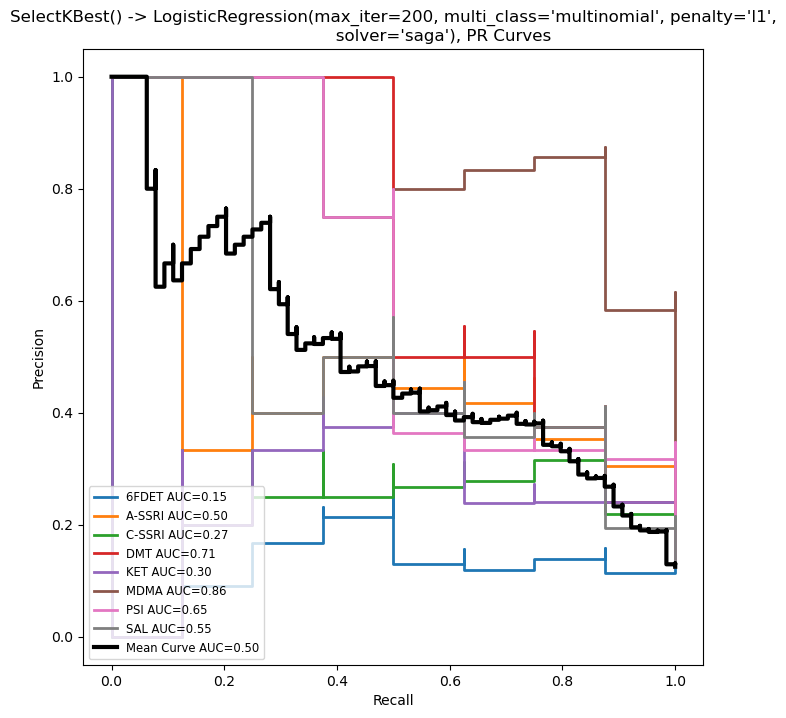

Real: 0.41 accuracy with a standard deviation of 0.12


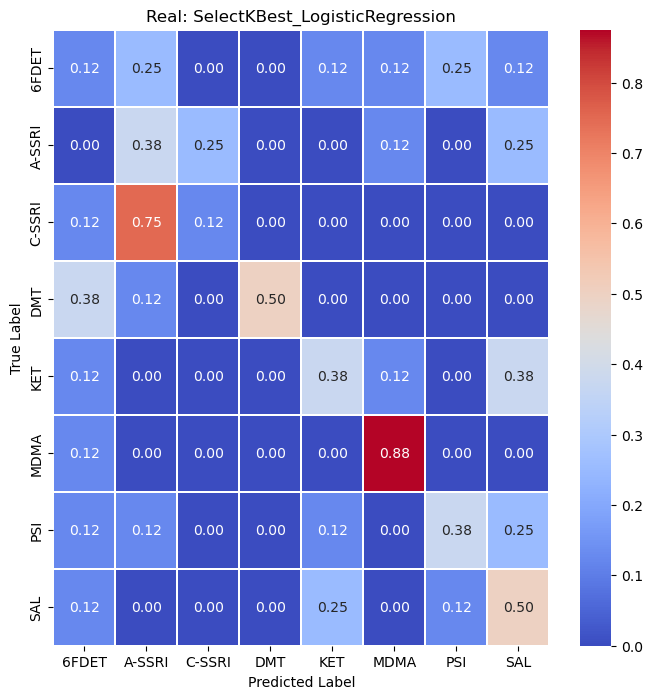

==== 6FDET ==== 
 Features per Model: [9, 8, 10, 10, 10, 10, 8, 10]
Parameters: 
 classif__C: [0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.01] 

Total Regions = 21 
 Present 1x: 9 - Clus14, Clus6, AP, PRP, Clus41, LA, Clus33, MEPO, Clus30
Present 2x: 1 - Clus16
Present 3x: 2 - Clus20, DMX
Present 4x: 1 - Clus11
Present 5x: 2 - Clus5, y
Present 6x: 1 - Clus10
Present 7x: 2 - Clus17, Clus37
Present 8x: 3 - Clus9, Clus12, Clus13

 
==== A-SSRI ==== 
 Features per Model: [9, 8, 10, 10, 10, 10, 8, 10]
Parameters: 
 classif__C: [0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.01] 

Total Regions = 21 
 Present 1x: 11 - Clus14, Clus6, AP, PRP, Clus41, LA, Clus16, Clus33, MEPO, Clus20, Clus30
Present 3x: 2 - y, DMX
Present 4x: 1 - Clus11
Present 5x: 1 - Clus5
Present 6x: 2 - Clus10, Clus37
Present 7x: 1 - Clus13
Present 8x: 3 - Clus9, Clus12, Clus17

 
==== C-SSRI ==== 
 Features per Model: [9, 8, 10, 10, 10, 10, 8, 10]
Parameters: 
 classif__C: [0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.00

c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.01}


c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\sklearn\linea

{'classif__C': 0.001}


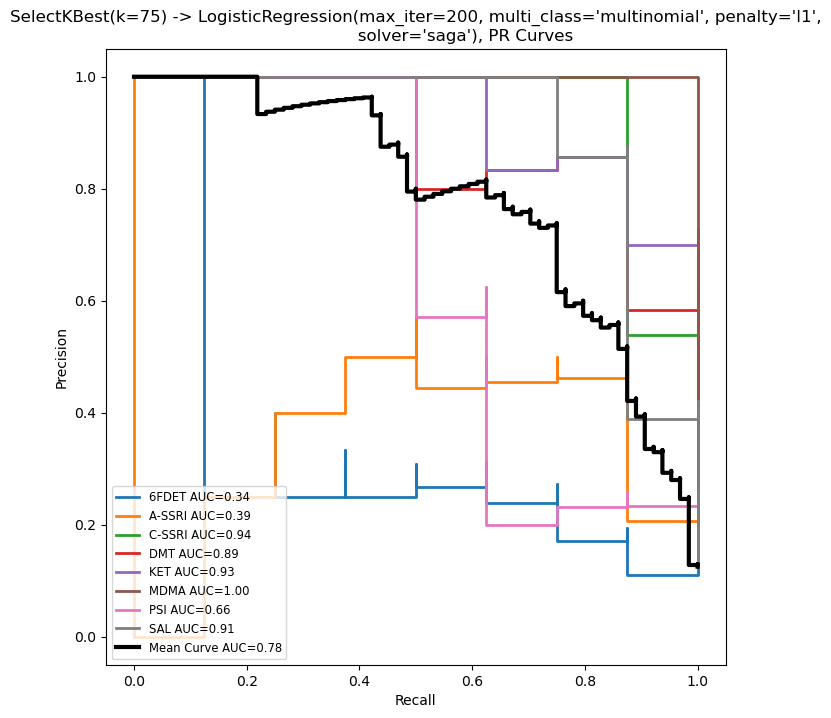

Real: 0.72 accuracy with a standard deviation of 0.12


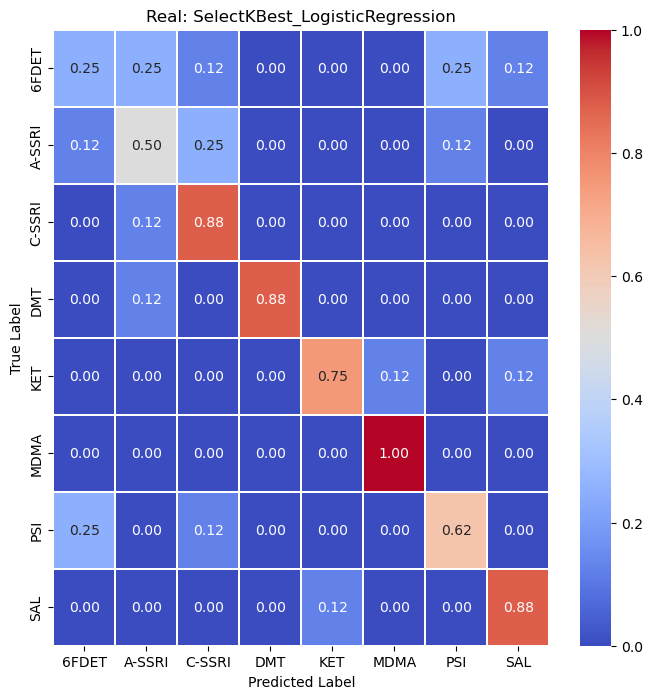

==== 6FDET ==== 
 Features per Model: [50, 51, 52, 54, 58, 56, 75, 52]
Parameters: 
 classif__C: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01, 0.001] 

Total Regions = 94 
 Present 1x: 21 - MEV, Clus52, PMd, IG, LM, VLPO, IO, NOD, PRP, x, y, Clus11, Clus23, Clus25, Clus27, Clus39, Clus51, BAC, PS, TMd, Clus29
Present 2x: 10 - Clus18, RL, SPIV, Clus35, CLI, AVPV, SubG, TMv, XII, Clus37
Present 3x: 4 - SLC, Clus31, VMH, Clus36
Present 4x: 5 - SCs, VPMpc, AP, Clus46, RPO
Present 5x: 10 - DG, MEPO, PVa, Clus4, Clus33, CUN, IF, SPA, Clus6, Clus13
Present 6x: 9 - CU, Clus2, Clus3, Clus8, Clus45, AUDd, NB, Clus19, Clus20
Present 7x: 9 - BST, NDB, SAG, TU, Clus9, Clus15, Clus16, Clus21, Clus34
Present 8x: 26 - BA, CEA, DMX, FS, IC, LA, LC, MM, PDTg, PT, SH, VISpl, Clus1, Clus5, Clus7, Clus10, Clus12, Clus14, Clus17, Clus22, Clus24, Clus30, Clus32, Clus38, Clus41, Clus47

 
==== A-SSRI ==== 
 Features per Model: [50, 51, 52, 54, 58, 56, 75, 52]
Parameters: 
 classif__C: [0.001, 0.001, 0.001,

In [15]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Identify parameters of feature clustering, per
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

classifyDict = dict()
classifyDict['featureSel_scale'] = False # True, False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
# classifyDict['featureSel_linkage'] = 'ward'  # 'average', 'complete', 'single', 'ward' (if euclidean)
# classifyDict['featureSel_distance'] = 'euclidean' # 'correlation, 'cosine', 'euclidean'

classifyDict['featureSel_filter'] = True
classifyDict['featureSel_agg'] = True
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster

classifyDict['data'] = 'cell_density' #cell_density, count
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'drug'

classifyDict['model'] = 'LogRegL1'
# classifyDict['model'] = 'LogRegL2'
# classifyDict['model'] = 'LogRegElastic'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'

classifyDict['model_featureSel'] = 'Univar' # 'Univar', 'mutInfo', 'RFE'
# classifyDict['model_featureSel_k'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
classifyDict['model_featureSel_k'] = [10, 75]
# classifyDict['model_featureSel_k'] = [1, 2, 3]

classifyDict['shuffle'] = False
classifyDict['includeSAL'] = True
classifyDict['include6FDET'] = True
classifyDict['gridCV'] = True

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl')

# Big Data - the dataset prior to filtering based on summary structures
# lightsheet_data = pd.read_pickle('lightsheet_data_big.pkl')
# lightsheet_data.rename(columns={'Brain Area': 'Brain_Area'}, inplace=True)

# Pure visualizations
# plotFunctions.data_heatmap(lightsheet_data_filt, classifyDict, dirDict)
# plotFunctions.data_heatmap_single(lightsheet_data, classifyDict, dirDict)

# Statistics
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

dimRedTech = 1
# Generate example data
# data, labels = make_blobs(n_samples=64, centers=4, n_features=297, random_state=42)

if classifyDict['featureSel_filter']:
    pandasdf = helperFunctions.filter_and_agg_Data(lightsheet_data, classifyDict)

# if classifyDict['featureSel_agg']:
if 0:
    ls_data_agg = helperFunctions.agg_cluster(pandasdf, classifyDict, dirDict)
else:
    ls_data_agg = pandasdf.pivot(index='dataset', columns=classifyDict['feature'], values=classifyDict['data'])    

ls_data_agg = ls_data_agg.sample(frac=1)

# X, y, featureNames, numYDict = hf.reformatData(pandasdf, classifyDict)
X = np.array(ls_data_agg.values)
# y = np.array([x[0:-1] for x in np.array(ls_data_agg.index)])
yStr = np.array([x[0:-1] for x in np.array(ls_data_agg.index)])
yDict = dict(zip(np.unique(yStr), range(1, len(np.unique(yStr))+1)))
y = np.array([yDict[x] for x in yStr])

data = X
labels = y
dimCount = 3

# Perform PCA
if dimRedTech == 1:
    pca = PCA(n_components=dimCount)
    data_pca = pca.fit_transform(data)
    axesLabel = 'PC '
    plotTitle = "PCA Scatter Plot"
    dimRedTitle = f"Top{dimCount}_PCA"
elif dimRedTech == 2:
    lda = LinearDiscriminantAnalysis(n_components=dimCount)
    data_pca = lda.fit_transform(data, labels)
    axesLabel = 'LD '
    plotTitle = "LDA Scatter Plot"
    dimRedTitle = f"Top{dimCount}_LDA"


# Create a scatter plot of the first two PCs, color-coded by labels
PCAset = [[1, 2], [2, 3], [1, 3]]

fig, axes = plt.subplots(nrows=1, ncols=dimCount,
                    figsize=(18, 5))

for idx, PCset in enumerate(PCAset):

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('Dark2', len(unique_labels))

    for i, label in enumerate(unique_labels):
        axes[idx].scatter(data_pca[labels == label, PCset[0]-1], data_pca[labels == label, PCset[1]-1], color=colors(i), label=f"Label {label}")

    # Add title, legend, and axis labels
    axes[idx].set_title(plotTitle)
    axes[idx].set_xlabel(f"{axesLabel}{PCset[0]}")
    axes[idx].set_ylabel(f"{axesLabel}{PCset[1]}")
    axes[idx].legend(np.unique(yStr))

    plt.savefig(dirDict['classifyDir'] + dimRedTitle + '.png', dpi=300, format='png', bbox_inches='tight')

# Display the plot
plt.show()
